# The landscape of a parametrized quantum circuit

Here, $U_{1:k}$ and $U_{k+1:N}$ are two random circuits. $U_k(\eta)$ is a rotation gate defined as $U_k(\eta) = e^{-i\Xi \eta/2}$ with $\Xi^2 = 1$.

> Nakanishi, Ken M., Keisuke Fujii, and Synge Todo. "Sequential minimal optimization for quantum-classical hybrid algorithms." arXiv preprint arXiv:1903.12166 (2019).

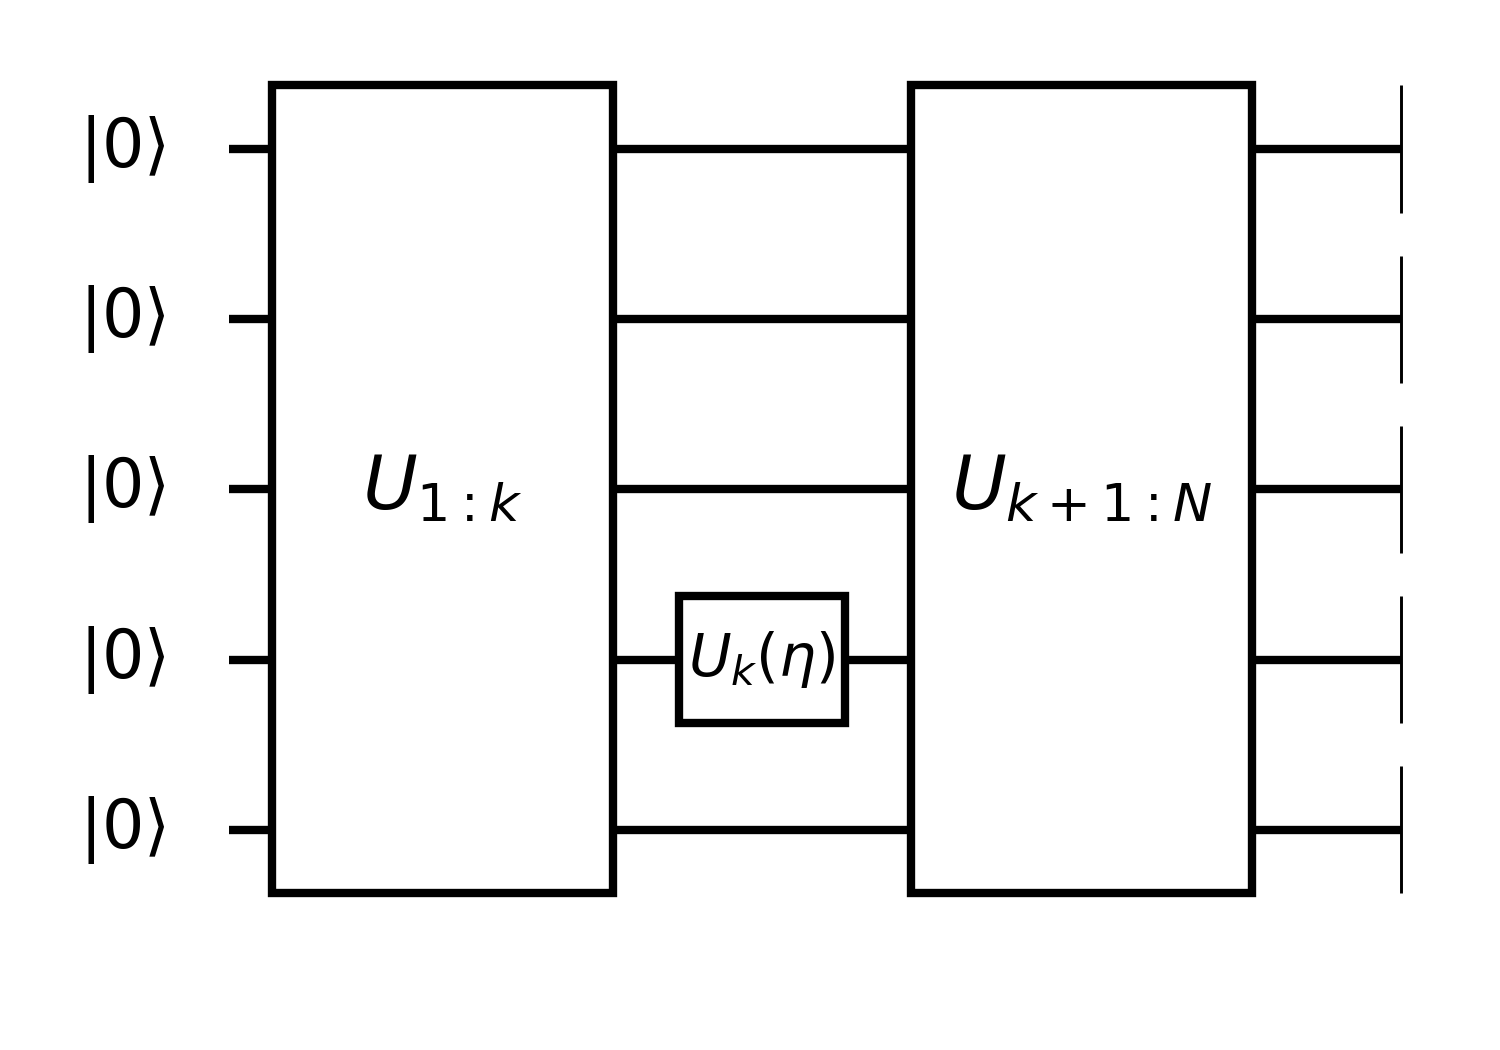

In [28]:
# the version of Yao is 0.4.1 in this notebook
using Yao, Yao.ConstGate
using Plots, LaTeXStrings

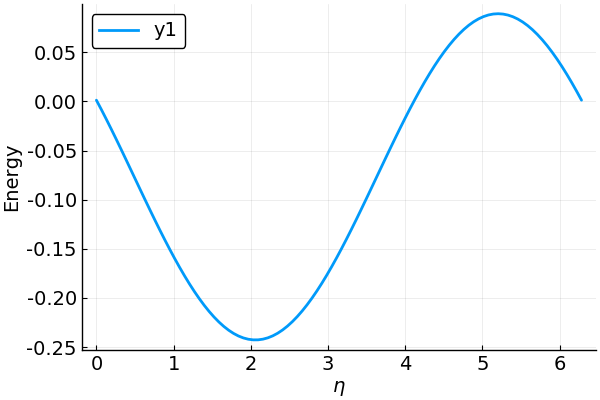

In [29]:
function scan_params(Uj, observable, nparam::Int)
    x = LinRange(0, 2π, nparam)
    y = zeros(nparam)
    for (i,x) in enumerate(x)
        dispatch!(Uj, x)
        y[i] = expect(observable, zero_state(N) |> c) |> real
    end
    x, y
end

N = 5

V1j = rand_unitary(1<<N) |> matblock
V2j = rand_unitary(1<<N) |> matblock

Uj = put(N, 4=>Rx(0.0))
c = chain(N, [V1j, Uj, V2j])

observable = put(N, 4=>Z)
xs, ys = scan_params(Uj, observable, 100)

# see a sine curve
pyplot()
fnt = Plots.font("Helvetica", 10.0)
default(titlefont=fnt, guidefont=fnt, tickfont=fnt, legendfont=fnt)
ax = plot(xs, ys, lw=2, xlabel=L"\eta", ylabel="Energy")

# Variational Quantum Eigensolver

## Two site Hubbard Model

In [30]:
"""get the hamiltonian of a Hubbard model"""
function hubbard_hamiltonain(t::Real, U::Real)
    0.5t * (kron(X, Z, X, I2) +
        kron(Y, Z, Y, I2) + 
        kron(I2, X, Z, X) +
        kron(I2, Y, Z, Y)) +
    0.25U * (kron(Z, Z, I2, I2) +
        kron(I2, I2, Z, Z))
end

hubbard_hamiltonain

In [31]:
hami = hubbard_hamiltonain(1, 1)

nqubits: 4, datatype: Complex{Float64}
sum
├─ [scale: 0.5] sum
│     ├─ kron
│     │  ├─ 1=>X gate
│     │  ├─ 2=>Z gate
│     │  ├─ 3=>X gate
│     │  └─ 4=>I2 gate
│     ├─ kron
│     │  ├─ 1=>Y gate
│     │  ├─ 2=>Z gate
│     │  ├─ 3=>Y gate
│     │  └─ 4=>I2 gate
│     ├─ kron
│     │  ├─ 1=>I2 gate
│     │  ├─ 2=>X gate
│     │  ├─ 3=>Z gate
│     │  └─ 4=>X gate
│     └─ kron
│        ├─ 1=>I2 gate
│        ├─ 2=>Y gate
│        ├─ 3=>Z gate
│        └─ 4=>Y gate
└─ [scale: 0.25] sum
      ├─ kron
      │  ├─ 1=>Z gate
      │  ├─ 2=>Z gate
      │  ├─ 3=>I2 gate
      │  └─ 4=>I2 gate
      └─ kron
         ├─ 1=>I2 gate
         ├─ 2=>I2 gate
         ├─ 3=>Z gate
         └─ 4=>Z gate


In [32]:
ishermitian(hami)

true

In [33]:
Hmat = mat(hami)

16×16 SparseArrays.SparseMatrixCSC{Complex{Float64},Int64} with 24 stored entries:
  [1 ,  1]  =  0.5+0.0im
  [5 ,  2]  =  1.0+0.0im
  [9 ,  3]  =  1.0+0.0im
  [4 ,  4]  =  0.5+0.0im
  [7 ,  4]  =  -1.0+0.0im
  [10,  4]  =  1.0+0.0im
  [2 ,  5]  =  1.0+0.0im
  [6 ,  6]  =  -0.5+0.0im
  [4 ,  7]  =  -1.0+0.0im
  [7 ,  7]  =  -0.5+0.0im
  [13,  7]  =  -1.0+0.0im
  [14,  8]  =  -1.0+0.0im
  [3 ,  9]  =  1.0+0.0im
  [4 , 10]  =  1.0+0.0im
  [10, 10]  =  -0.5+0.0im
  [13, 10]  =  1.0+0.0im
  [11, 11]  =  -0.5+0.0im
  [15, 12]  =  -1.0+0.0im
  [7 , 13]  =  -1.0+0.0im
  [10, 13]  =  1.0+0.0im
  [13, 13]  =  0.5+0.0im
  [8 , 14]  =  -1.0+0.0im
  [12, 15]  =  -1.0+0.0im
  [16, 16]  =  0.5+0.0im

In [34]:
using KrylovKit

In [35]:
?eigsolve

search: eigsolve geneigsolve



```
eigsolve(A::AbstractMatrix, [howmany = 1, which = :LM, T = eltype(A)]; kwargs...)
eigsolve(f, n::Int, [howmany = 1, which = :LM, T = Float64]; kwargs...)
eigsolve(f, x₀, [howmany = 1, which = :LM]; kwargs...)
eigsolve(f, x₀, howmany, which, algorithm)
```

Compute at least `howmany` eigenvalues from the linear map encoded in the matrix `A` or by the function `f`. Return eigenvalues, eigenvectors and a `ConvergenceInfo` structure.

### Arguments:

The linear map can be an `AbstractMatrix` (dense or sparse) or a general function or callable object. If an `AbstractMatrix` is used, a starting vector `x₀` does not need to be provided, it is then chosen as `rand(T, size(A,1))`. If the linear map is encoded more generally as a a callable function or method, the best approach is to provide an explicit starting guess `x₀`. Note that `x₀` does not need to be of type `AbstractVector`, any type that behaves as a vector and supports the required methods (see KrylovKit docs) is accepted. If instead of `x₀` an integer `n` is specified, it is assumed that `x₀` is a regular vector and it is initialized to `rand(T,n)`, where the default value of `T` is `Float64`, unless specified differently.

The next arguments are optional, but should typically be specified. `howmany` specifies how many eigenvalues should be computed; `which` specifies which eigenvalues should be targetted. Valid specifications of `which` are given by

  * `:LM`: eigenvalues of largest magnitude
  * `:LR`: eigenvalues with largest (most positive) real part
  * `:SR`: eigenvalues with smallest (most negative) real part
  * `:LI`: eigenvalues with largest (most positive) imaginary part, only if `T <: Complex`
  * `:SI`: eigenvalues with smallest (most negative) imaginary part, only if `T <: Complex`
  * [`EigSorter(f; rev = false)`](@ref): eigenvalues `λ` that appear first (or last if   `rev == true`) when sorted by `f(λ)`

!!! note "Note about selecting `which` eigenvalues"
    Krylov methods work well for extremal eigenvalues, i.e. eigenvalues on the periphery of the spectrum of the linear map. All of they valid `Symbol`s for `which` have this property, but could also be specified usign `EigSorter`, e.g. `:LM` is equivalent to `Eigsorter(abs; rev = true)`. Note that smallest magnitude sorting is obtained using e.g. `EigSorter(abs; rev = false)`, but since no (shift-and)-invert is used, this will only be successfull if you somehow know that eigenvalues close to zero are also close to the periphery of the spectrum.


The argument `T` acts as a hint in which `Number` type the computation should be performed, but is not restrictive. If the linear map automatically produces complex values, complex arithmetic will be used even though `T<:Real` was specified. However, if the linear map and initial guess are real, approximate eigenvalues will be searched for using a partial Schur factorization, which implies that complex conjugate eigenvalues come in pairs and cannot be split. It is then illegal to choose `which` in a way that would treat `λ` and `conj(λ)` differently, i.e. `:LI` and `:SI` are invalid, as well as any `EigSorter` that would lead to `by(λ) != by(conj(λ))`.

### Return values:

The return value is always of the form `vals, vecs, info = eigsolve(...)` with

  * `vals`: a `Vector` containing the eigenvalues, of length at least `howmany`, but could   be longer if more eigenvalues were converged at the same cost. Eigenvalues will be real   if [`Lanczos`](@ref) was used and complex if [`Arnoldi`](@ref) was used (see below).
  * `vecs`: a `Vector` of corresponding eigenvectors, of the same length as `vals`. Note   that eigenvectors are not returned as a matrix, as the linear map could act on any   custom Julia type with vector like behavior, i.e. the elements of the list `vecs` are   objects that are typically similar to the starting guess `x₀`, up to a possibly   different `eltype`. In particular  for a general matrix (i.e. with `Arnoldi`) the   eigenvectors are generally complex and are therefore always returned in a complex   number format. When the linear map is a simple `AbstractMatrix`, `vecs` will be   `Vector{Vector{<:Number}}`.
  * `info`: an object of type [`ConvergenceInfo`], which has the following fields

      * `info.converged::Int`: indicates how many eigenvalues and eigenvectors were actually   converged to the specified tolerance `tol` (see below under keyword arguments)
      * `info.residual::Vector`: a list of the same length as `vals` containing the   residuals `info.residual[i] = f(vecs[i]) - vals[i] * vecs[i]`
      * `info.normres::Vector{<:Real}`: list of the same length as `vals` containing the   norm of the residual `info.normres[i] = norm(info.residual[i])`
      * `info.numops::Int`: number of times the linear map was applied, i.e. number of times   `f` was called, or a vector was multiplied with `A`
      * `info.numiter::Int`: number of times the Krylov subspace was restarted (see below)

!!! warning "Check for convergence"
    No warning is printed if not all requested eigenvalues were converged, so always check if `info.converged >= howmany`.


### Keyword arguments:

Keyword arguments and their default values are given by:

  * `verbosity::Int = 0`: verbosity level, i.e. 0 (no messages), 1 (single message   at the end), 2 (information after every iteration), 3 (information per Krylov step)
  * `tol::Real`: the requested accuracy (corresponding to the 2-norm of the residual for   Schur vectors, not the eigenvectors). If you work in e.g. single precision (`Float32`),   you should definitely change the default value.
  * `krylovdim::Integer`: the maximum dimension of the Krylov subspace that will be   constructed. Note that the dimension of the vector space is not known or checked, e.g.   `x₀` should not necessarily support the `Base.length` function. If you know the actual   problem dimension is smaller than the default value, it is useful to reduce the value of   `krylovdim`, though in principle this should be detected.
  * `maxiter::Integer`: the number of times the Krylov subspace can be rebuilt; see below   for further details on the algorithms.
  * `orth::Orthogonalizer`: the orthogonalization method to be used, see   [`Orthogonalizer`](@ref)
  * `issymmetric::Bool`: if the linear map is symmetric, only meaningful if `T<:Real`
  * `ishermitian::Bool`: if the linear map is hermitian

The default values are given by `tol = KrylovDefaults.tol`, `krylovdim = KrylovDefaults.krylovdim`, `maxiter = KrylovDefaults.maxiter`, `orth = KrylovDefaults.orth`; see [`KrylovDefaults`](@ref) for details.

The default value for the last two parameters depends on the method. If an `AbstractMatrix` is used, `issymmetric` and `ishermitian` are checked for that matrix, ortherwise the default values are `issymmetric = false` and `ishermitian = T <: Real && issymmetric`. When values for the keyword arguments are provided, no checks will be performed even in the matrix case.

### Algorithm

The last method, without default values and keyword arguments, is the one that is finally called, and can also be used directly. Here, one specifies the algorithm explicitly as either [`Lanczos`](@ref), for real symmetric or complex hermitian problems, or [`Arnoldi`](@ref), for general problems. Note that these names refer to the process for building the Krylov subspace, but the actual algorithm is an implementation of the Krylov-Schur algorithm, which can dynamically shrink and grow the Krylov subspace, i.e. the restarts are so-called thick restarts where a part of the current Krylov subspace is kept.

!!! note "Note about convergence"
    In case of a general problem, where the `Arnoldi` method is used, convergence of an eigenvalue is not based on the norm of the residual `norm(f(vecs[i]) - vals[i]*vecs[i])` for the eigenvector but rather on the norm of the residual for the corresponding Schur vectors.

    See also [`schursolve`](@ref) if you want to use the partial Schur decomposition directly, or if you are not interested in computing the eigenvectors, and want to work in real arithmetic all the way true (if the linear map and starting guess are real).



In [36]:
x0 = randn(ComplexF64, size(Hmat, 2)) |> normalize!
E, V = eigsolve(Hmat, x0, 1, :SR)
EG = E[1]

-2.0615528128088276

## Differential programming to obtain the ground state

In [37]:
using Zygote: gradient
using Zygote

In [38]:
using LinearAlgebra

E, V = eigen(Hmat |> Matrix)
@show E[1]

E[1] = -2.0615528128088267


-2.0615528128088267

In [39]:
f(x) = real(x'*Hmat*x/(x'*x))[]

x = randn(ComplexF64, size(Hmat, 2))
α = 0.5

for i = 1:100
    g = f'(x)
    x -= α .* g
    println("Energy is $(f(x))")
end

Energy is 0.22666801364824013
Energy is 0.11131886054443056
Energy is 0.002457927656256108
Energy is -0.09946397880125618
Energy is -0.19440169258022058
Energy is -0.28263939070603716
Energy is -0.36470215668593525
Energy is -0.44126943258983126
Energy is -0.5130992743100669
Energy is -0.5809674557950162
Energy is -0.6456218463454786
Energy is -0.7077503450601299
Energy is -0.7679597693646811
Energy is -0.826763059346681
Energy is -0.8845725891969145
Energy is -0.9416979776559967
Energy is -0.9983473716885012
Energy is -1.05463163752743
Energy is -1.1105711865511603
Energy is -1.1661052857019898
Energy is -1.2211036754536415
Energy is -1.2753801831262588
Energy is -1.3287078277199973
Energy is -1.3808347206899039
Energy is -1.4314999269100988
Energy is -1.4804483995626974
Energy is -1.5274441593978876
Energy is -1.5722810471601572
Energy is -1.61479061195212
Energy is -1.6548469688406073
Energy is -1.6923687237376712
Energy is -1.7273182861734429
Energy is -1.759699047153199
Energy is 

In [40]:
using Random
using QuAlgorithmZoo: random_diff_circuit
using Plots
Random.seed!(2);

In [41]:
function train!(circuit, hami; maxiter=200, α=0.3)
    nbit = nqubits(circuit)
    rots = collect_blocks(RotationGate, circuit)
    loss_history = Float64[]
    for i in 0:maxiter
        for (j,r) in enumerate(rots)
            dispatch!(+, r, π/2)
            E₊ = expect(hami, zero_state(nbit) |> circuit) |> real
            dispatch!(-, r, π)
            E₋ = expect(hami, zero_state(nbit) |> circuit) |> real
            dispatch!(+, r, π/2)
            g = 0.5(E₊ - E₋)
            dispatch!(-, r, α*g)
        end
        push!(loss_history, expect(hami, zero_state(nbit) |> circuit) |> real)
        
        if i%10 == 0
            println("Iter $i, E = $(loss_history[end])")
        end
    end
    loss_history, circuit
end

train! (generic function with 1 method)

In [42]:
circuit = random_diff_circuit(4, 2, [1=>2, 2=>3, 3=>4, 4=>1])

nqubits: 4, datatype: Complex{Float64}
chain
├─ chain
│  ├─ chain
│  │  ├─ put on (1)
│  │  │  └─ rot(X gate, 0.0)
│  │  └─ put on (1)
│  │     └─ rot(Z gate, 0.0)
│  ├─ chain
│  │  ├─ put on (2)
│  │  │  └─ rot(X gate, 0.0)
│  │  └─ put on (2)
│  │     └─ rot(Z gate, 0.0)
│  ├─ chain
│  │  ├─ put on (3)
│  │  │  └─ rot(X gate, 0.0)
│  │  └─ put on (3)
│  │     └─ rot(Z gate, 0.0)
│  └─ chain
│     ├─ put on (4)
│     │  └─ rot(X gate, 0.0)
│     └─ put on (4)
│        └─ rot(Z gate, 0.0)
├─ chain
│  ├─ control(1)
│  │  └─ (2,) X gate
│  ├─ control(2)
│  │  └─ (3,) X gate
│  ├─ control(3)
│  │  └─ (4,) X gate
│  └─ control(4)
│     └─ (1,) X gate
├─ chain
│  ├─ chain
│  │  ├─ put on (1)
│  │  │  └─ rot(Z gate, 0.0)
│  │  ├─ put on (1)
│  │  │  └─ rot(X gate, 0.0)
│  │  └─ put on (1)
│  │     └─ rot(Z gate, 0.0)
│  ├─ chain
│  │  ├─ put on (2)
│  │  │  └─ rot(Z gate, 0.0)
│  │  ├─ put on (2)
│  │  │  └─ rot(X gate, 0.0)
│  │  └─ put on (2)
│  │     └─ rot(Z gate, 0.0)
│  ├─ chain
│  │  

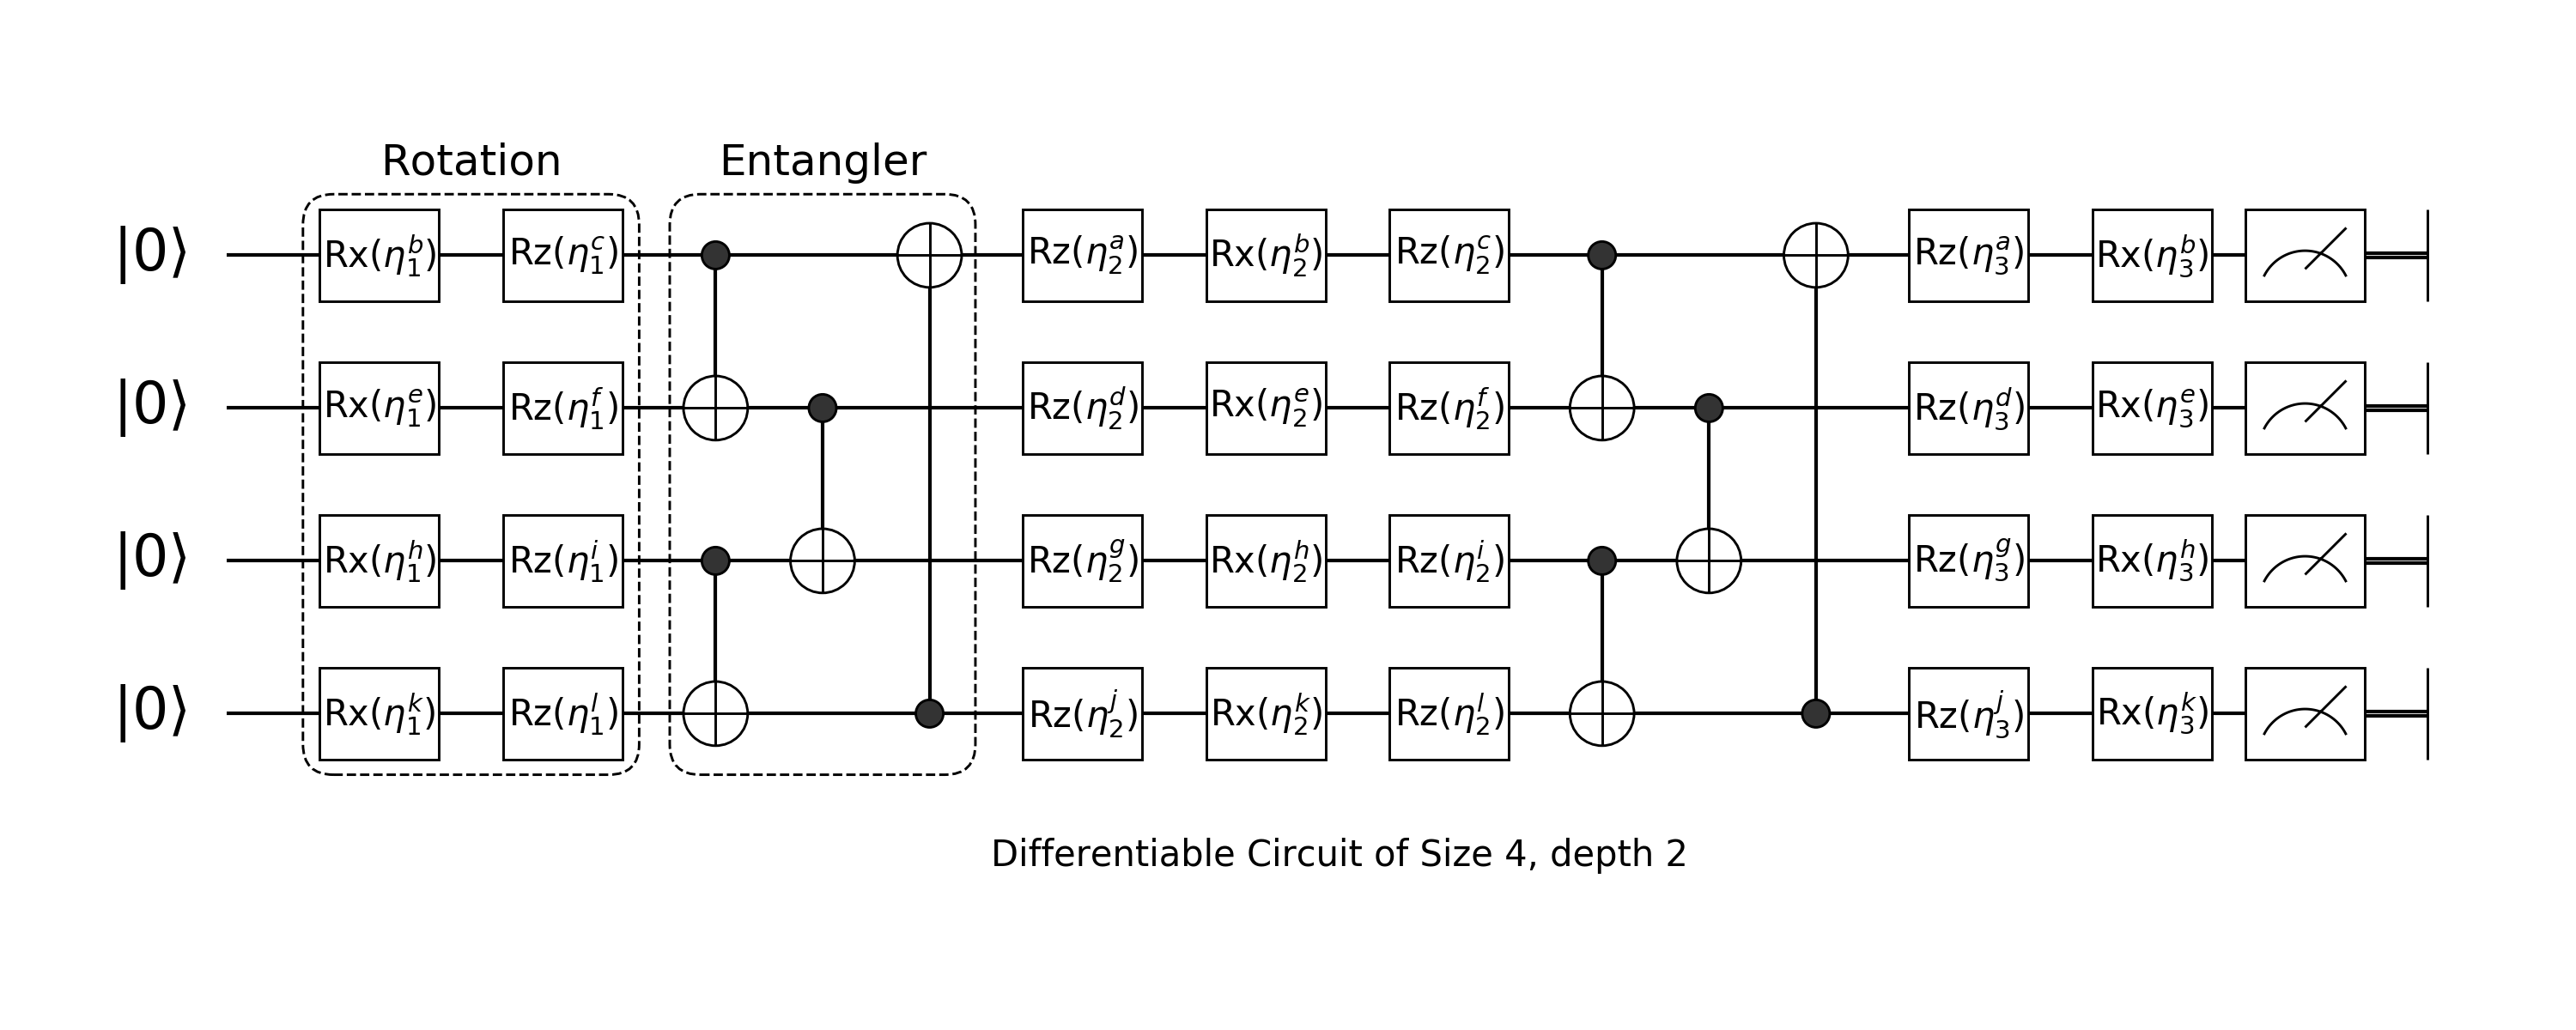

In [43]:
expect(hami, rand_state(4))

-0.35253669297396184 - 1.734723475976807e-18im

In [44]:
train!(dispatch!(circuit, :random), hami; maxiter=1000)

Iter 0, E = 0.1331457495868531
Iter 10, E = -0.9855303775878353
Iter 20, E = -1.2297955326313268
Iter 30, E = -1.9142937704748313
Iter 40, E = -2.049605803218168
Iter 50, E = -2.060489756340246
Iter 60, E = -2.0614341280106534
Iter 70, E = -2.0615385176045344
Iter 80, E = -2.0615510453788284
Iter 90, E = -2.0615525917224944
Iter 100, E = -2.0615527849758575
Iter 110, E = -2.0615528092908484
Iter 120, E = -2.0615528123629607
Iter 130, E = -2.061552812752211
Iter 140, E = -2.061552812801631
Iter 150, E = -2.0615528128079132
Iter 160, E = -2.0615528128087144
Iter 170, E = -2.061552812808816
Iter 180, E = -2.061552812808828
Iter 190, E = -2.0615528128088307
Iter 200, E = -2.06155281280883
Iter 210, E = -2.0615528128088303
Iter 220, E = -2.061552812808829
Iter 230, E = -2.0615528128088307
Iter 240, E = -2.06155281280883
Iter 250, E = -2.0615528128088307
Iter 260, E = -2.061552812808831
Iter 270, E = -2.0615528128088307
Iter 280, E = -2.0615528128088303
Iter 290, E = -2.06155281280883
Iter 3

([0.133146, -0.0189387, -0.19048, -0.378445, -0.565894, -0.72406, -0.835082, -0.903543, -0.943936, -0.968687  …  -2.06155, -2.06155, -2.06155, -2.06155, -2.06155, -2.06155, -2.06155, -2.06155, -2.06155, -2.06155], nqubits: 4, datatype: Complex{Float64}
chain
├─ chain
│  ├─ chain
│  │  ├─ put on (1)
│  │  │  └─ rot(X gate, 1.138621687317084)
│  │  └─ put on (1)
│  │     └─ rot(Z gate, 0.8585240974715916)
│  ├─ chain
│  │  ├─ put on (2)
│  │  │  └─ rot(X gate, 6.328271240363392e-16)
│  │  └─ put on (2)
│  │     └─ rot(Z gate, 0.11994832844542769)
│  ├─ chain
│  │  ├─ put on (3)
│  │  │  └─ rot(X gate, 0.9532258307583561)
│  │  └─ put on (3)
│  │     └─ rot(Z gate, 0.050430442156283714)
│  └─ chain
│     ├─ put on (4)
│     │  └─ rot(X gate, -4.440892098500626e-16)
│     └─ put on (4)
│        └─ rot(Z gate, 0.7085839331430747)
├─ chain
│  ├─ control(1)
│  │  └─ (2,) X gate
│  ├─ control(2)
│  │  └─ (3,) X gate
│  ├─ control(3)
│  │  └─ (4,) X gate
│  └─ control(4)
│     └─ (1,) X gate
├─

## If we have time, I will show the analytical approach for two-site Hubbard model

In [45]:
m = [0.5 1 -1 0; 1 -0.5 0 1; -1 0 -0.5 -1; 0 1 -1 0.5]

4×4 Array{Float64,2}:
  0.5   1.0  -1.0   0.0
  1.0  -0.5   0.0   1.0
 -1.0   0.0  -0.5  -1.0
  0.0   1.0  -1.0   0.5

In [46]:
mat(0.5kron(Z,Z)- kron(Z,X)+kron(X,Z)) |> Matrix

4×4 Array{Complex{Float64},2}:
  0.5+0.0im   1.0+0.0im  -1.0+0.0im   0.0+0.0im
  1.0+0.0im  -0.5+0.0im   0.0+0.0im   1.0+0.0im
 -1.0+0.0im   0.0+0.0im  -0.5+0.0im  -1.0+0.0im
  0.0+0.0im   1.0+0.0im  -1.0+0.0im   0.5+0.0im

In [47]:
eigen(m)

Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
eigenvalues:
4-element Array{Float64,1}:
 -2.0615528128088267
 -0.5               
  0.5000000000000018
  2.0615528128088303
eigenvectors:
4×4 Array{Float64,2}:
 -0.435162  0.0       -0.707107      0.557345
  0.557345  0.707107  -4.71028e-16   0.435162
 -0.557345  0.707107   4.71028e-16  -0.435162
 -0.435162  0.0        0.707107      0.557345

In [48]:
E_exact = sqrt(4.25)

2.0615528128088303

# Gradient Vanishing Problem

In [53]:
using Statistics

function rand_gradient(hami::AbstractBlock)
    N = nqubits(hami)
    V1j = rand_unitary(1<<N) |> matblock
    V2j = rand_unitary(1<<N) |> matblock

    Uj = put(N, 1=>Rx(0.0))
    c = chain(N, [V1j, Uj, V2j])
    
    η = rand()*2π
    dispatch!(Uj, η+π/2)
    y₊ = expect(hami, zero_state(N) |> c) |> real

    dispatch!(Uj, η-π/2)
    y₋ = expect(hami, zero_state(N) |> c) |> real
    (y₊ - y₋)/2
end

maxN = 9
grad_vars = [mean([abs(rand_gradient(put(N, 1=>Z))) for i=1:100]) for N=1:maxN]

9-element Array{Float64,1}:
 0.4059330395956129  
 0.25136200168409156 
 0.1970885973573447  
 0.12772870055240237 
 0.109690519544569   
 0.07760827186061026 
 0.05082867358284546 
 0.03170525147755411 
 0.021470617399368067

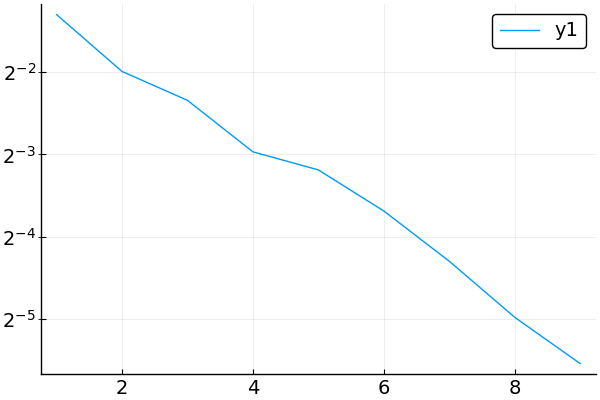

In [56]:
# see a exponential decreasing curve
ax = plot(1:maxN, grad_vars, yscale=:log2)